## Objetivo del Notebook

Se quiere mejorar el modelo antiguo de predicción para el cuadl míñimo, este modelo se basaba en predecir el comportamiento de de los mínimos mensuales, sin emabrgo lo que interesa es predecir el valor mínimo de esta serie de tiempo por lo que se cambiará la metodología a una que involucre Teoría de Valores Extremos (EVT).

### Librerías Necesarias

En este caso se utilizará PyTorch para la creación del modelo Gated Recurrent Units (GRU) aprovechando del GPU para acelerar el proceso mediante CUDA.

In [226]:
## Librerias

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, f1_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from scipy.stats import genpareto
from scipy.stats import norm

In [97]:
## Activar GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 4060 Laptop GPU


### Metodología

Se usará la metodología de Teoría de Valores Extremos propuesta en el paper Modeling Extreme Values in Time Series sin embargo se usará únicamente el umbral del percentil 5% para predecir únicamente los mínimos. 
Se harán clases internas y funciones para facilitar la creación del modelo y su posterior entrenamiento y evaluación.

### 1.1 Cargar Serie de Tiempo

In [214]:
df = pd.read_csv('../../data/Brujo/BaseCompletaBrujo.csv',parse_dates=['fecha']).sort_values(by = 'fecha')
df = df.set_index('fecha')
serie = df['caudal_minimo']

### 1.2 Análisis de la serie de tiempo

C:\Users\andre\AppData\Local\Temp\ipykernel_25708\2747525971.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


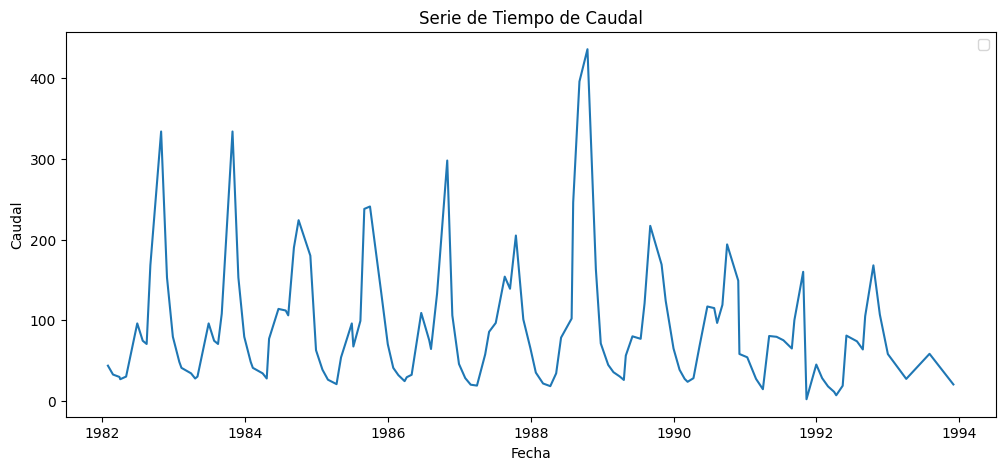

In [215]:
plt.figure(figsize=(12,5))
plt.plot(serie)
plt.title('Serie de Tiempo de Caudal')
plt.xlabel('Fecha')
plt.ylabel('Caudal')
plt.legend()
plt.show()

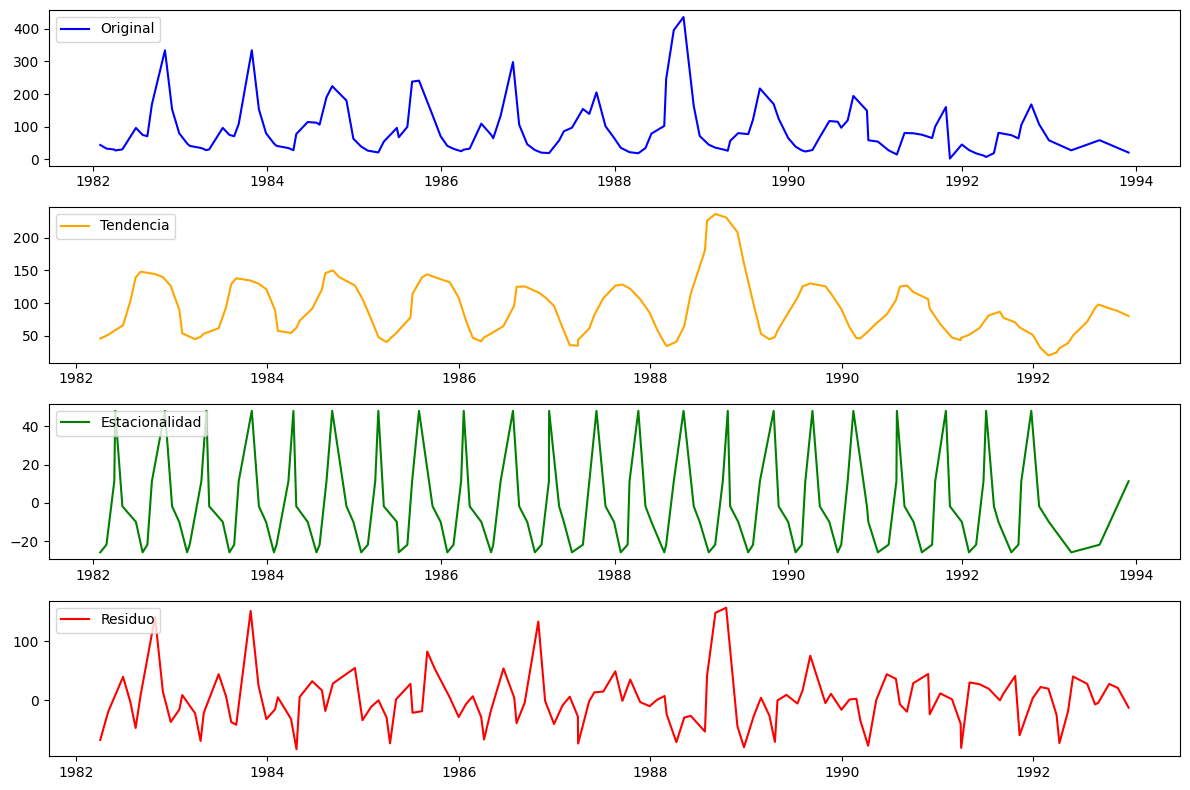

In [216]:
descomposicion = seasonal_decompose(serie, model='additive', period = 6)
trend = descomposicion.trend
seasonal = descomposicion.seasonal
residual = descomposicion.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(serie, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendencia', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuo', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [217]:
umbral_min = serie.quantile(0.10)
extremos_min = serie[serie < umbral_min]

In [218]:
extremos_min

fecha
1985-04-13    20.700000
1987-02-28    20.000000
1987-03-31    18.900000
1987-04-01    18.900000
1988-03-04    21.500000
1988-04-10    18.200000
1991-03-31    15.100000
1991-04-02    14.400000
1991-11-11     2.000000
1992-02-29    17.900000
1992-03-31    11.200000
1992-04-11     6.900000
1992-05-14    18.700000
1993-12-01    20.334795
Name: caudal_minimo, dtype: float64

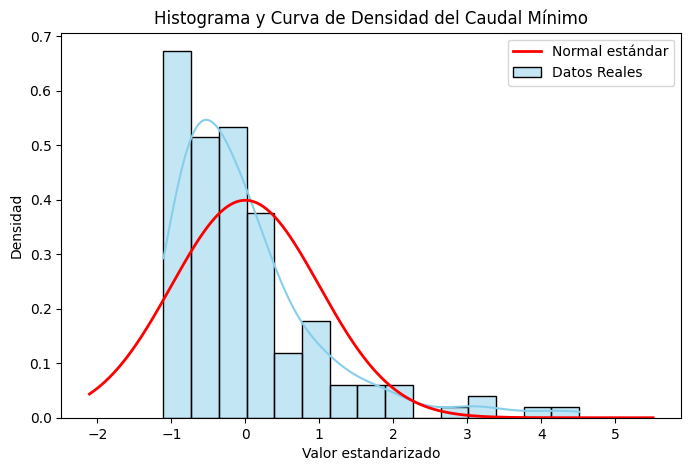

In [228]:
# Serie estandarizada
serie_std = (df['caudal_minimo'] - df['caudal_minimo'].mean()) / df['caudal_minimo'].std()

# Histograma con KDE
plt.figure(figsize=(8,5))
sns.histplot(serie_std, kde=True, stat='density', color='skyblue', edgecolor='black', label = 'Datos Reales')

# Curva de la normal estándar
x = np.linspace(serie_std.min()-1, serie_std.max()+1, 1000)
plt.plot(x, norm.pdf(x, 0, 1), color='red', lw=2, label='Normal estándar')

# Detalles del gráfico
plt.title('Histograma y Curva de Densidad del Caudal Mínimo')
plt.xlabel('Valor estandarizado')
plt.ylabel('Densidad')
plt.legend()
plt.show()

### 1.3 Varas Estadísticas UNI-VARIADA

Se graficará un Mean Residual Life PLot para elegir el umbral sobre el cual vamos a analizar los mínimos

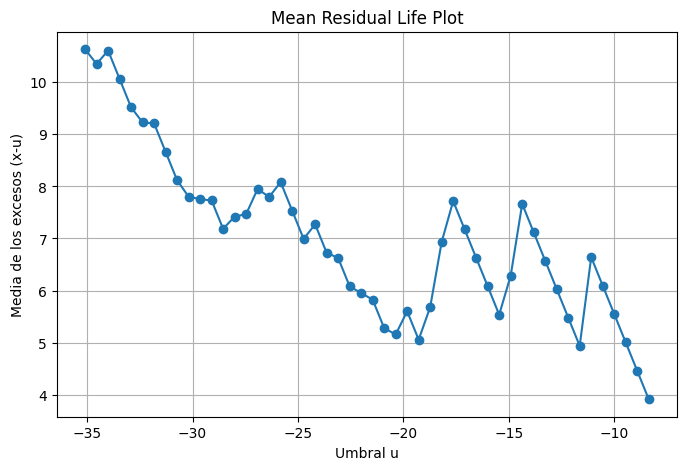

In [119]:
serie = -df['caudal_minimo']
umbral = np.linspace(np.percentile(serie, 70), np.percentile(serie,99), 50)
mean_excess = []

for u in umbral:
    excesses = serie[serie > u] - u
    mean_excess.append(excesses.mean() if len(excesses) > 0 else 0)

plt.figure(figsize=(8,5))
plt.plot(umbral, mean_excess, marker='o')
plt.xlabel('Umbral u')
plt.ylabel('Media de los excesos (x-u)')
plt.title('Mean Residual Life Plot')
plt.grid(True)
plt.show()

In [135]:
slopes= np.diff(mean_excess)/np.diff(umbral)
optimal_idx = np.where(slopes >0)[0][0] if len(np.where(slopes>0)[0]) > 0 else len(umbral)//2
umbral_optimo = umbral[optimal_idx]

print('Umbral Óptimo : ', umbral_optimo)

Umbral Óptimo :  -34.554326530612244


In [125]:
excesos = serie[serie > umbral_optimo] - umbral_optimo
num_excesos = len(excesos)
print('Numero de Excesos: ', {num_excesos})
print('Proporción de Excesos: ', {num_excesos/len(serie)})

Numero de Excesos:  {40}
Proporción de Excesos:  {0.2962962962962963}


In [128]:
params = genpareto.fit(excesos, floc=0) 
shape, loc, scale = params
print(f"Parámetros GPD - Shape (ξ): {shape:.4f}, Scale (σ): {scale:.4f}")

Parámetros GPD - Shape (ξ): -0.3691, Scale (σ): 14.0515


Text(0.5, 1.0, 'Gráfico Q-Q')

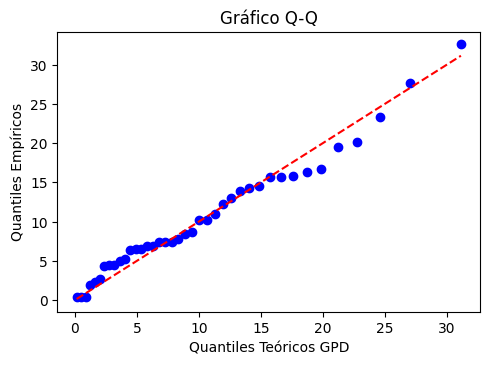

In [130]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 3)
sorted_excess = np.sort(excesos)
theoretical_quantiles = genpareto.ppf(np.linspace(0.01, 0.99, len(sorted_excess)), shape, loc=0, scale=scale)
plt.plot(theoretical_quantiles, sorted_excess, 'bo')
plt.plot([min(theoretical_quantiles), max(theoretical_quantiles)], [min(theoretical_quantiles), max(theoretical_quantiles)], 'r--')
plt.xlabel('Quantiles Teóricos GPD')
plt.ylabel('Quantiles Empíricos')
plt.title('Gráfico Q-Q')
        

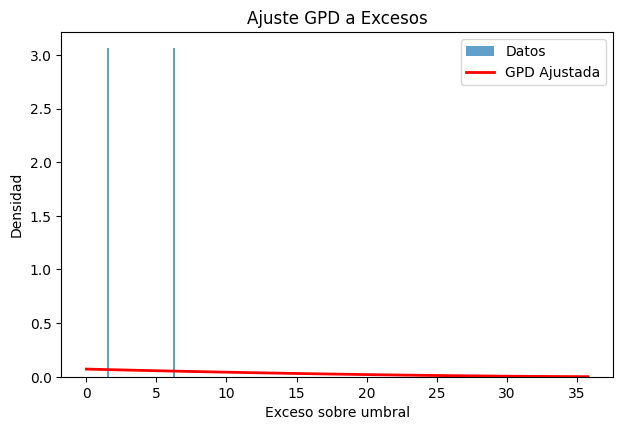

In [133]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 4)
x = np.linspace(0, max(excesos)*1.1, 100)
pdf = genpareto.pdf(x, shape, loc=0, scale=scale)
plt.hist(excesses, bins=30, density=True, alpha=0.7, label='Datos')
plt.plot(x, pdf, 'r-', lw=2, label='GPD Ajustada')
plt.xlabel('Exceso sobre umbral')
plt.ylabel('Densidad')
plt.title('Ajuste GPD a Excesos')
plt.legend()
        
plt.tight_layout()
plt.show()

### 2.1 Time Series Prediction

In [104]:
outputs = df.iloc[:, 0]
inputs = df.iloc[:, 1:]

In [105]:
N = len(df)
T = 5

X_sucesion, Y_sucesion = [], []

for i in range(N-T+1):
    X_sucesion.append(inputs[i:i+T])
    Y_sucesion.append(outputs[i:i+T])

### 2.2 Eventos Extremos